
# 🧠 BMI Training (Classic ML) — EfficientNetB0 Embeddings + Numeric Features

This notebook trains **classic ML regressors** (Linear, Ridge, Lasso, DecisionTree, RandomForest, XGB if available)
using **EfficientNetB0 embeddings** + numeric features (`Height_cm`, `Weight_kg`, `Age`).


In [1]:

# Install dependencies if needed
# !pip install tensorflow pillow pandas numpy scikit-learn xgboost matplotlib tqdm joblib


In [2]:

import os, math, json, joblib, numpy as np, pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, classification_report, accuracy_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

try:
    from xgboost import XGBRegressor
    XGB_AVAILABLE = True
except Exception:
    XGB_AVAILABLE = False

import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array

import matplotlib.pyplot as plt
from pathlib import Path

print("libraries loaded successfully.")


libraries loaded successfully.


In [3]:

# Config
CSV_PATH = 'bmi.csv'
IMAGE_DIR = 'dataset/Celeb-FBI Dataset'
IMAGE_SIZE = (224, 224)
NUMERIC_COLS = ['Height_cm', 'Weight_kg', 'Age']
os.makedirs('models', exist_ok=True)
os.makedirs('artifacts', exist_ok=True)


In [4]:

# Load and clean data
df = pd.read_csv(CSV_PATH)
df['Filename2'] = df['Filename2'].astype(str).str.strip()
df['ImagePath'] = df['Filename2'].apply(lambda x: os.path.join(IMAGE_DIR, x))
df = df[df['ImagePath'].apply(os.path.exists)].dropna(subset=['BMI']).reset_index(drop=True)
for c in NUMERIC_COLS:
    df[c] = df[c].fillna(df[c].median())
print("✅ Loaded", len(df), "rows")
df.head()


✅ Loaded 6222 rows


,Filename,Filename2,Height_cm,Weight_kg,BMI,Age,ImagePath
0,D:\FBI CELEBS\Celeb-FBI Dataset\303_5.1h_54w_f...,303_5.1h_54w_female_45a.png,154.94,54.0,22.493998,45.0,dataset/Celeb-FBI Dataset\303_5.1h_54w_female_...
1,D:\FBI CELEBS\Celeb-FBI Dataset\304_5.9h_70w_f...,304_5.9h_70w_female_31a.png,175.26,70.0,22.789376,31.0,dataset/Celeb-FBI Dataset\304_5.9h_70w_female_...
2,D:\FBI CELEBS\Celeb-FBI Dataset\305_5.11h_60w_...,305_5.11h_60w_female_29a.png,155.19,60.0,24.912871,29.0,dataset/Celeb-FBI Dataset\305_5.11h_60w_female...
3,D:\FBI CELEBS\Celeb-FBI Dataset\308_5.5h_53w_f...,308_5.5h_53w_female_30a.png,165.10,53.0,19.443826,30.0,dataset/Celeb-FBI Dataset\308_5.5h_53w_female_...
4,D:\FBI CELEBS\Celeb-FBI Dataset\309_5.8h_68w_f...,309_5.8h_68w_female_35a.png,172.72,68.0,22.794163,35.0,dataset/Celeb-FBI Dataset\309_5.8h_68w_female_...


In [5]:
# --- Feature extraction via EfficientNetB0 ---
try:
    base_model = EfficientNetB0(
        weights="imagenet",
        include_top=False,
        pooling="avg",
        input_shape=(224, 224, 3)
    )
except ValueError:
    # fallback if grayscale mixup triggers pretrained mismatch
    print("⚠️ Grayscale image mix detected — using untrained EfficientNet weights.")
    base_model = EfficientNetB0(
        weights=None,
        include_top=False,
        pooling="avg",
        input_shape=(224, 224, 3)
    )

def extract_embeddings(paths):
    feats = []
    for p in tqdm(paths, desc="Extracting embeddings"):
        try:
            img = load_img(p, target_size=(224, 224))  # Pillow auto-detects and we'll fix mode below
            if img.mode != "RGB":
                img = img.convert("RGB")  # force RGB here
            arr = img_to_array(img)
            arr = np.expand_dims(arr, 0)
            arr = preprocess_input(arr)
            feat = base_model.predict(arr, verbose=0)
            feats.append(feat[0])
        except Exception as e:
            print(f"⚠️ {p} skipped: {e}")
            feats.append(np.zeros((1280,)))
    return np.array(feats)

# Cache embeddings to speed up re-runs
emb_cache = Path("artifacts/effnet_embeddings.npy")
if emb_cache.exists():
    print("📂 Loading cached embeddings:", emb_cache)
    embeddings = np.load(emb_cache)
else:
    embeddings = extract_embeddings(df["ImagePath"])
    np.save(emb_cache, embeddings)
    print("💾 Saved embeddings to:", emb_cache)

print("✅ Embeddings shape:", embeddings.shape)


⚠️ Grayscale image mix detected — using untrained EfficientNet weights.
📂 Loading cached embeddings: artifacts\effnet_embeddings.npy
✅ Embeddings shape: (6222, 1280)


In [6]:

# Combine embeddings + numeric features
num_scaler = StandardScaler()
X_num = num_scaler.fit_transform(df[NUMERIC_COLS])
joblib.dump(num_scaler, 'models/numeric_scaler.pkl')

X = np.hstack([embeddings, X_num])
y = df['BMI'].values

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
print("Train:", X_train.shape, "Val:", X_val.shape)


Train: (4977, 1283) Val: (1245, 1283)


In [7]:

# Scale for linear models
feat_scaler = StandardScaler()
X_train_scaled = feat_scaler.fit_transform(X_train)
X_val_scaled = feat_scaler.transform(X_val)
joblib.dump(feat_scaler, 'models/feature_scaler.pkl')


['models/feature_scaler.pkl']

In [8]:

# Train classic ML regressors
models = {
    "LinearRegression": LinearRegression(),
    "RidgeRegression": Ridge(alpha=1.0),
    "LassoRegression": Lasso(alpha=0.0005, max_iter=10000),
    "DecisionTree": DecisionTreeRegressor(random_state=42),
    "RandomForest": RandomForestRegressor(n_estimators=400, random_state=42, n_jobs=-1),
}
if XGB_AVAILABLE:
    models["XGBRegressor"] = XGBRegressor(n_estimators=400, learning_rate=0.05, max_depth=7, n_jobs=-1, random_state=42)

results = []
for name, mdl in models.items():
    print(f"\n🧠 Training {name}...")
    use_scaled = name in ['LinearRegression','RidgeRegression','LassoRegression']
    Xtr, Xva = (X_train_scaled if use_scaled else X_train), (X_val_scaled if use_scaled else X_val)
    mdl.fit(Xtr, y_train)
    preds = mdl.predict(Xva)
    r2 = r2_score(y_val, preds)
    mae = mean_absolute_error(y_val, preds)
    rmse = math.sqrt(mean_squared_error(y_val, preds))
    print(f"{name}: R²={r2:.4f}, MAE={mae:.3f}, RMSE={rmse:.3f}")
    results.append([name,r2,mae,rmse])



🧠 Training LinearRegression...
LinearRegression: R²=0.9689, MAE=0.599, RMSE=0.880

🧠 Training RidgeRegression...
RidgeRegression: R²=0.9763, MAE=0.481, RMSE=0.769

🧠 Training LassoRegression...


c:\Users\7gnik\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.239e+01, tolerance: 1.084e+01
  model = cd_fast.enet_coordinate_descent(


LassoRegression: R²=0.9764, MAE=0.477, RMSE=0.766

🧠 Training DecisionTree...
DecisionTree: R²=0.9259, MAE=0.245, RMSE=1.358

🧠 Training RandomForest...
RandomForest: R²=0.9579, MAE=0.174, RMSE=1.024

🧠 Training XGBRegressor...
XGBRegressor: R²=0.9703, MAE=0.135, RMSE=0.859


In [9]:

res = pd.DataFrame(results, columns=['Model','R2','MAE','RMSE']).sort_values(by='R2', ascending=False)
best_model_name = res.iloc[0]['Model']
print("\n✅ Best model:", best_model_name)
res



✅ Best model: LassoRegression


,Model,R2,MAE,RMSE
2,LassoRegression,0.976436,0.476594,0.765723
1,RidgeRegression,0.976261,0.481421,0.768555
5,XGBRegressor,0.970319,0.135354,0.859375
0,LinearRegression,0.968875,0.599285,0.880030
4,RandomForest,0.957864,0.173612,1.023940
3,DecisionTree,0.925918,0.245251,1.357695


In [10]:

# Save best model
best_model = models[best_model_name]
joblib.dump(best_model, f"models/{best_model_name}_bmi.pkl")
print("✅ Saved:", f"models/{best_model_name}_bmi.pkl")


✅ Saved: models/LassoRegression_bmi.pkl


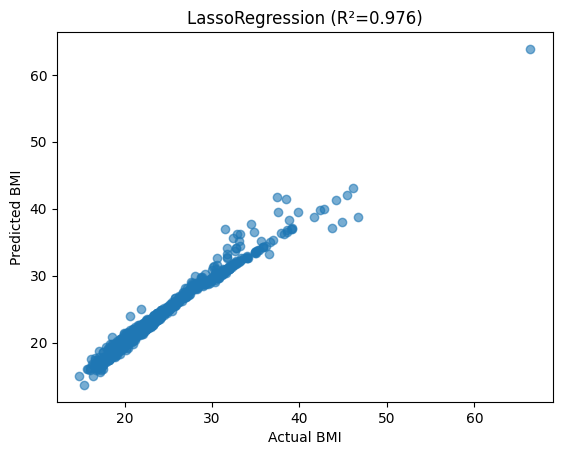

              precision    recall  f1-score   support

      Normal       0.97      0.95      0.96       819
       Obese       0.98      0.91      0.94       151
  Overweight       0.84      0.95      0.89       160
 Underweight       0.79      0.86      0.82       115

    accuracy                           0.94      1245
   macro avg       0.90      0.92      0.90      1245
weighted avg       0.94      0.94      0.94      1245

Accuracy: 0.9365461847389558


In [11]:

# Evaluate and plot
from sklearn.metrics import confusion_matrix
val_preds = best_model.predict(X_val_scaled if best_model_name in ['LinearRegression','RidgeRegression','LassoRegression'] else X_val)

plt.scatter(y_val, val_preds, alpha=0.6)
plt.xlabel("Actual BMI"); plt.ylabel("Predicted BMI")
plt.title(f"{best_model_name} (R²={r2_score(y_val,val_preds):.3f})")
plt.show()

def bmi_cat(b):
    if b<18.5: return "Underweight"
    elif b<25: return "Normal"
    elif b<30: return "Overweight"
    else: return "Obese"

y_true_cat = [bmi_cat(x) for x in y_val]
y_pred_cat = [bmi_cat(x) for x in val_preds]

print(classification_report(y_true_cat, y_pred_cat))
print("Accuracy:", accuracy_score(y_true_cat, y_pred_cat))
